In [1]:

import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import boolforge
import os

# Get the absolute path of the current notebook
notebook_dir = os.path.abspath("")
img_dir = os.path.join(notebook_dir, 'img')

print("Current notebook path:", notebook_dir)

Current notebook path: c:\Users\venka\Desktop\UCLA\AttractorCoherence


In [2]:

import os

# Get the absolute path of the current notebook
notebook_dir = os.path.abspath("")

print("Current notebook path:", notebook_dir)




Current notebook path: c:\Users\venka\Desktop\UCLA\AttractorCoherence


In [3]:
import importlib.util

package_name = 'cana'

if importlib.util.find_spec(package_name) is not None:
    print(f"The package '{package_name}' is installed.")
else:
    print(f"The package '{package_name}' is not installed.")


The package 'cana' is installed.


In [4]:
def rolling_mean(data, window_size,min_periods=1):
    if window_size <= 0:
        raise ValueError("Window size must be greater than 0")
    
    return pd.DataFrame(data).rolling(window=window_size,min_periods = min_periods,closed='both').mean()

def running_max(data):
    running_maxs = []
    maximum = data[0]
    for num in data:
        if num>maximum:
            maximum = num
        running_maxs.append(maximum)
    return running_maxs

def running_min(data):
    running_mins = []
    minimum = data[-1]
    for num in data[::-1]:
        if num<minimum:
            minimum = num
        running_mins.append(minimum)
    return running_mins[::-1]

def get_auc(x,y,n_points):
    assert len(x)==len(y),'x and y need to be of same length'
    indices = np.argsort(x)
    x_sorted = np.sort(x)
    y_sorted = np.array(y)[indices]
    x_equidistant = np.linspace(x_sorted[0],x_sorted[-1],n_points)
    y_equidistant = []
    for x_value in x_equidistant:
        distances_to_x_value = np.abs(x_sorted - x_value)
        y_equidistant.append( np.mean(y_sorted[distances_to_x_value == min(distances_to_x_value)]) )
    return np.mean(y_equidistant)


# Alternate AUC function
def get_auc(x,y,n_points):
    assert len(x)==len(y),'x and y need to be of same length'
    indices = np.argsort(x)
    x_sorted = np.sort(x)
    y_sorted = np.array(y)[indices]
    x_equidistant = np.linspace(x_sorted[0],x_sorted[-1],n_points)
    y_mean = []
    for i in range(len(x_equidistant)-1):
        mask = (x_sorted >= x_equidistant[i]) & (x_sorted < x_equidistant[i+1])
        if np.any(mask):
            y_mean.append(np.mean(y_sorted[mask]))
        else:
            y_mean.append(0)  # or np.nan, depending on how you want to handle empty bins
    return np.mean(y_mean)


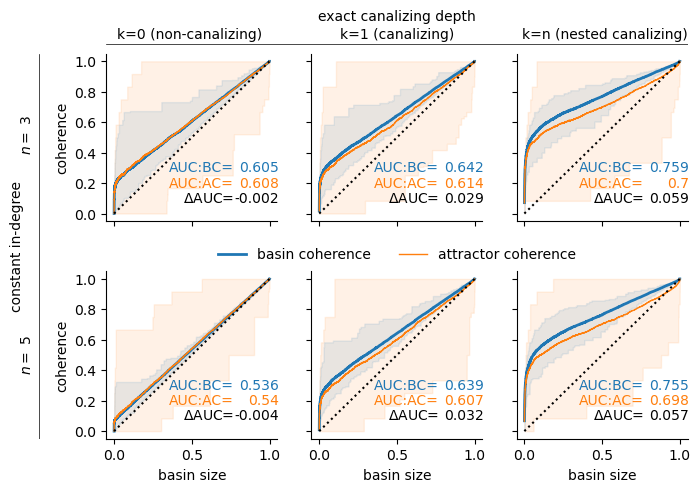

In [5]:
num_simulations = 10000
N = 12
ns = [3,5]
attractor_coherencess = []
basin_coherencess = []
basin_sizess = []
frozen_core_coherencess = []
for i,n in enumerate(ns):
    attractor_coherencess.append([])
    basin_coherencess.append([])
    basin_sizess.append([])
    frozen_core_coherencess.append([])
    for j,k in enumerate([0,1,n]):
        
        filename = f'data/canBNexactdepth_{N}_{n}_{k}_{num_simulations}.pkl'
        filename = os.path.join(notebook_dir, filename)
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
            attractor_coherencess[-1].append( np.array([entry for sub_list in data['all_attractor_coherences'] for entry in sub_list]) )
            basin_coherencess[-1].append( np.array([entry for sub_list in data['all_basin_coherences'] for entry in sub_list]) )
            basin_sizess[-1].append( np.array([entry for sub_list in data['all_basin_sizes'] for entry in sub_list]) )
            # frozen_core_coherencess[-1].append( np.array([entry[-1] for sub_list in data['all_frozen_core_coherence'] for entry in sub_list]) )

mean_attractor_coherencess = np.array([[np.mean(attractor_coherencess[i][j]) for j,k in enumerate([0,1,n])] for i,n in enumerate(ns)])
mean_basin_coherencess = np.array([[np.mean(basin_coherencess[i][j]) for j,k in enumerate([0,1,n])] for i,n in enumerate(ns)])

n_points = 1000
auc_attractor_coherencess = np.array([[get_auc(basin_sizess[i][j],attractor_coherencess[i][j],n_points) for j,k in enumerate([0,1,n])] for i,n in enumerate(ns)])
auc_basin_coherencess = np.array([[get_auc(basin_sizess[i][j],basin_coherencess[i][j],n_points) for j,k in enumerate([0,1,n])] for i,n in enumerate(ns)])


cmap = matplotlib.cm.tab10
window_size = 500
f,ax = plt.subplots(2,3,figsize=(7.5,5),sharex='col',sharey='row')
OPTION='area'
SHOW_AUC_TEXT = True
for index_n,n in enumerate(ns):
    for j,k in enumerate([0,1,n]):
        ax[index_n,j].spines[['right', 'top']].set_visible(False)
        indices = np.argsort(basin_sizess[index_n][j])
        ax[index_n,j].plot(basin_sizess[index_n][j][indices],0.5*np.array(rolling_mean(basin_coherencess[index_n][j][indices],window_size)) + 0.5*np.array(rolling_mean(basin_coherencess[index_n][j][indices][::-1],window_size)[::-1]),color=cmap(0),label='basin coherence',lw=2)
        ax[index_n,j].plot(basin_sizess[index_n][j][indices],0.5*np.array(rolling_mean(attractor_coherencess[index_n][j][indices],window_size)) + 0.5*np.array(rolling_mean(attractor_coherencess[index_n][j][indices][::-1],window_size)[::-1]),color=cmap(1),label='attractor coherence',lw=1)

        
        if OPTION=='lines':
            ax[index_n,j].plot(basin_sizess[index_n][j][indices],running_max(basin_coherencess[index_n][j][indices]),color=cmap(0),ls=':',lw=1)
            ax[index_n,j].plot(basin_sizess[index_n][j][indices],running_min(basin_coherencess[index_n][j][indices]),color=cmap(0),ls=':',lw=1)
            ax[index_n,j].plot(basin_sizess[index_n][j][indices],running_max(attractor_coherencess[index_n][j][indices]),color=cmap(1),ls=':',lw=1)
            ax[index_n,j].plot(basin_sizess[index_n][j][indices],running_min(attractor_coherencess[index_n][j][indices]),color=cmap(1),ls=':',lw=1)
        elif OPTION=='area':
            ax[index_n,j].fill_between(basin_sizess[index_n][j][indices],running_min(attractor_coherencess[index_n][j][indices]),running_max(attractor_coherencess[index_n][j][indices]),color=cmap(1),alpha=0.1)
            ax[index_n,j].fill_between(basin_sizess[index_n][j][indices],running_min(basin_coherencess[index_n][j][indices]),running_max(basin_coherencess[index_n][j][indices]),color=cmap(0),alpha=0.1)
            
        ax[index_n,j].plot([0,1],[0,1],'k:')
        if index_n==1:
            ax[index_n,j].set_xlabel('basin size')
        if j==0:
            ax[index_n,j].set_ylabel('coherence')
        if index_n==1 and j==1:
            ax[index_n,j].legend(loc='center',ncol=2,frameon=False,bbox_to_anchor=[0.5,1.1])
        if SHOW_AUC_TEXT:
            ax[index_n,j].text(0.77,0.3,'AUC:BC=',ha='right',va='center',color=cmap(0))
            ax[index_n,j].text(0.77,0.2,'AUC:AC=',ha='right',va='center',color=cmap(1))
            ax[index_n,j].text(0.77,0.1,r'$\Delta$'+'AUC=',ha='right',va='center',color='k')
            ax[index_n,j].text(1.06,0.3,str(round(auc_basin_coherencess[index_n,j],3)),ha='right',va='center',color=cmap(0))
            ax[index_n,j].text(1.06,0.2,str(round(auc_attractor_coherencess[index_n,j],3)),ha='right',va='center',color=cmap(1))
            ax[index_n,j].text(1.06,0.1,str(round(auc_basin_coherencess[index_n,j]-auc_attractor_coherencess[index_n,j],3)),ha='right',va='center',color='k')

pos1 = ax[0, 0].get_position()
pos2 = ax[1, 2].get_position()
ax_left = f.add_axes([pos1.x0 - 0.1, pos2.y0, 0.02, pos1.y1 - pos2.y0])
ax_left.set_xticks([])
ax_left.set_yticks([])
for spine in ax_left.spines.values():
    spine.set_visible(False)
ax_left.plot([0,0],[0,1],'k-',lw=0.5)
ax_left.set_ylim([0,1])
ax_left.text(-0.16,0.5,'constant in-degree',ha='center',va='center',rotation=90)    
ax_left.text(-0.09,0.79,r'$n =$ '+str(ns[0]),ha='center',va='center',rotation=90)    
ax_left.text(-0.09,0.22,r'$n =$ '+str(ns[1]),ha='center',va='center',rotation=90)    

ax_top = f.add_axes([pos1.x0, pos1.y1 + 0.01, pos2.x1 - pos1.x0, 0.02])
ax_top.set_xticks([])
ax_top.set_yticks([])
for spine in ax_top.spines.values():
    spine.set_visible(False)
ax_top.plot([0,1],[0,0],'k-',lw=0.5)
ax_top.set_xlim([0,1])
ax_top.text(0.5,0.3,'exact canalizing depth',ha='center',va='center')    
ax_top.text(1/7,0.1,r'k=0' + ' (non-canalizing)',ha='center',va='center',rotation=0)    
ax_top.text(4/8,0.1,r'k=1' + ' (canalizing)',ha='center',va='center',rotation=0)    
ax_top.text(6/7,0.1,r'k=n' + ' (nested canalizing)',ha='center',va='center',rotation=0)    

plt.subplots_adjust(hspace=0.3)

plt.savefig(os.path.join(img_dir, f'basin_vs_attractor_coherence_random_{N}_{num_simulations}_{OPTION}_{SHOW_AUC_TEXT}.pdf'),bbox_inches='tight')
plt.show()

In [6]:
input_redundancies = []
strengths = []
biases = []
all_layer_structures = []
aucs_basin = []
aucs_attractor = []
difference_aucs = []
eff_degrees = []
bias_prod_times_eff_degrees = []
avg_sens = []
biases_prod = []
all_ns = []
all_ks = []
nsim = 500
EXACT_DEPTH = True

for ii,n in enumerate(ns):
    for jj,k in enumerate([0,1,n]):
        for _ in range(nsim):
            f = boolforge.random_function(n,k,EXACT_DEPTH=EXACT_DEPTH)
            input_redundancies.append(f.get_input_redundancy())
            strengths.append(f.get_canalizing_strength()[0])
            biases.append(f.get_absolute_bias())
            avg_sens.append(f.get_average_sensitivity(NORMALIZED=False,EXACT=True))
            aucs_basin.append(auc_basin_coherencess[ii,jj])
            aucs_attractor.append(auc_attractor_coherencess[ii,jj])
            difference_aucs.append(auc_basin_coherencess[ii,jj] - auc_attractor_coherencess[ii,jj])
            eff_degrees.append(n * (1-input_redundancies[-1]))
            biases_prod.append(0.25*(1-biases[-1]**2))
            bias_prod_times_eff_degrees.append(0.25*(1-biases[-1]**2) * n * (1-input_redundancies[-1]))
        all_ns.append(n)
        all_ks.append(k)

input_redundancies = np.reshape(input_redundancies,(len(ns),3,nsim))
strengths = np.reshape(strengths,(len(ns),3,nsim))
biases = np.reshape(biases,(len(ns),3,nsim))
avg_sens = np.reshape(avg_sens,(len(ns),3,nsim))
eff_degrees = np.reshape(eff_degrees,(len(ns),3,nsim))
bias_prod_times_eff_degrees = np.reshape(bias_prod_times_eff_degrees,(len(ns),3,nsim))
biases_prod = np.reshape(biases_prod,(len(ns),3,nsim))
mean_input_redundancies = input_redundancies.mean(2)
mean_strengths = strengths.mean(2)
mean_abs_biases = biases.mean(2)
mean_avg_sens = avg_sens.mean(2)
mean_eff_degrees = eff_degrees.mean(2)
mean_bias_prod_times_eff_degrees = bias_prod_times_eff_degrees.mean(2)
mean_biases_prod = biases_prod.mean(2)

A = np.array([auc_basin_coherencess,auc_attractor_coherencess,
              auc_basin_coherencess-auc_attractor_coherencess,
              mean_abs_biases,mean_avg_sens,mean_input_redundancies,mean_strengths,
              mean_eff_degrees,mean_bias_prod_times_eff_degrees,mean_biases_prod])   

df = pd.DataFrame(A.reshape((A.shape[0],len(ns)*3)),
                  columns = ['n=%i, k=%i' % (n,k) for n,k in zip(all_ns,all_ks)],
                  index = ['AUC basin coherence','AUC attractor coherence','Delta AUC',
                        'Absolute bias','Average sensitivity',
                        'Input redundancy','Canalizing strength',
                        'Effective degree','<K_e><p(1-p)>','<p(1-p)>'])
df.to_excel(os.path.join(img_dir, f'basin_vs_attractor_coherence_N{N}_EXACTDEPTH{EXACT_DEPTH}_table.xlsx'))
print(df)

                         n=3, k=0  n=3, k=1  n=3, k=3  n=5, k=0  n=5, k=1  \
AUC basin coherence      0.605182  0.642361  0.758760  0.536021  0.638540   
AUC attractor coherence  0.607629  0.613530  0.700095  0.539538  0.606588   
Delta AUC               -0.002447  0.028831  0.058665 -0.003516  0.031952   
Absolute bias            0.160000  0.500000  0.475000  0.130500  0.507125   
Average sensitivity      1.819000  1.500000  1.025000  2.519750  1.523875   
Input redundancy         0.269583  0.375000  0.526042  0.304331  0.531206   
Canalizing strength      0.262444  0.500000  0.755556  0.168461  0.436358   
Effective degree         2.191250  1.875000  1.421875  3.478346  2.343972   
<K_e><p(1-p)>            0.521965  0.351562  0.262939  0.846343  0.429302   
<p(1-p)>                 0.238375  0.187500  0.178125  0.243102  0.182678   

                         n=5, k=5  
AUC basin coherence      0.755391  
AUC attractor coherence  0.698301  
Delta AUC                0.057090  
Absolute

3 0 0
4 0 1
5 0 1
6 0 1
7 0 1


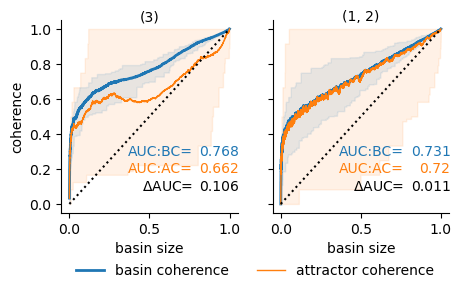

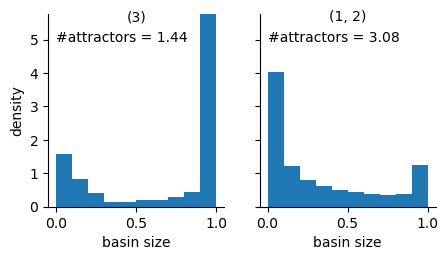

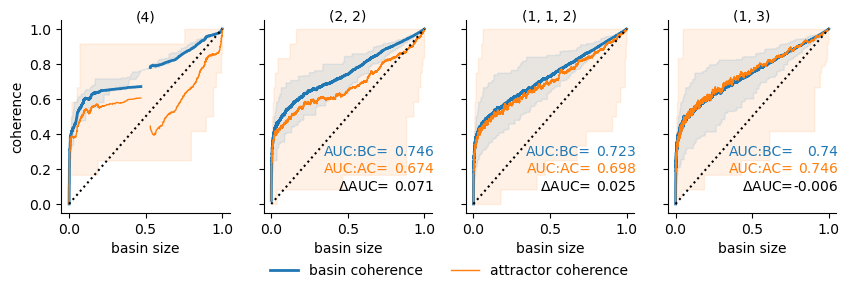

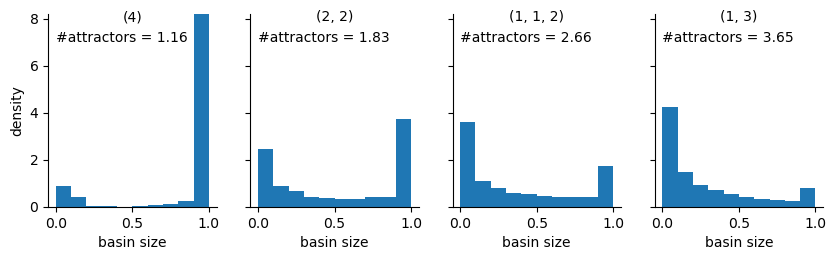

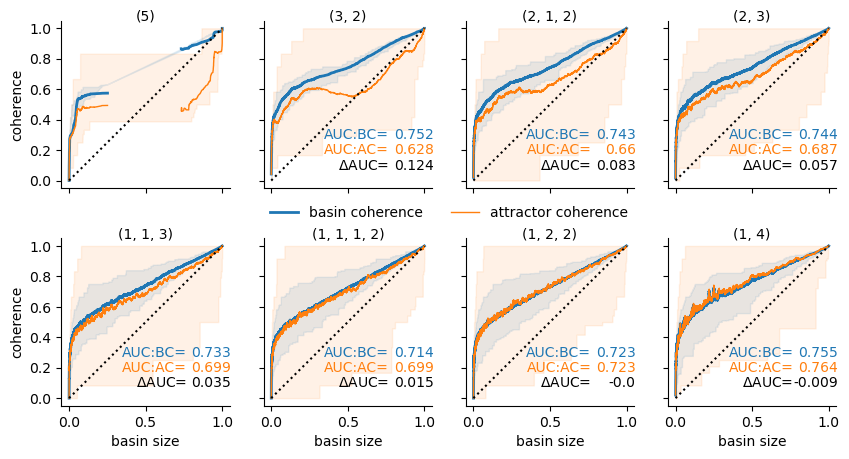

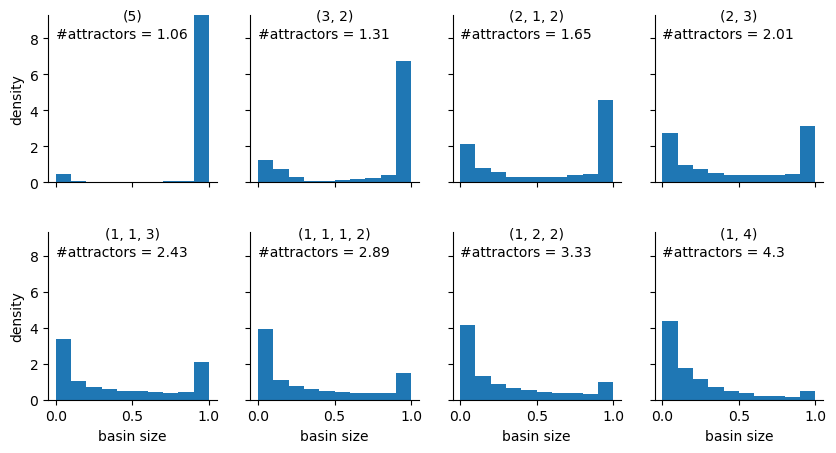

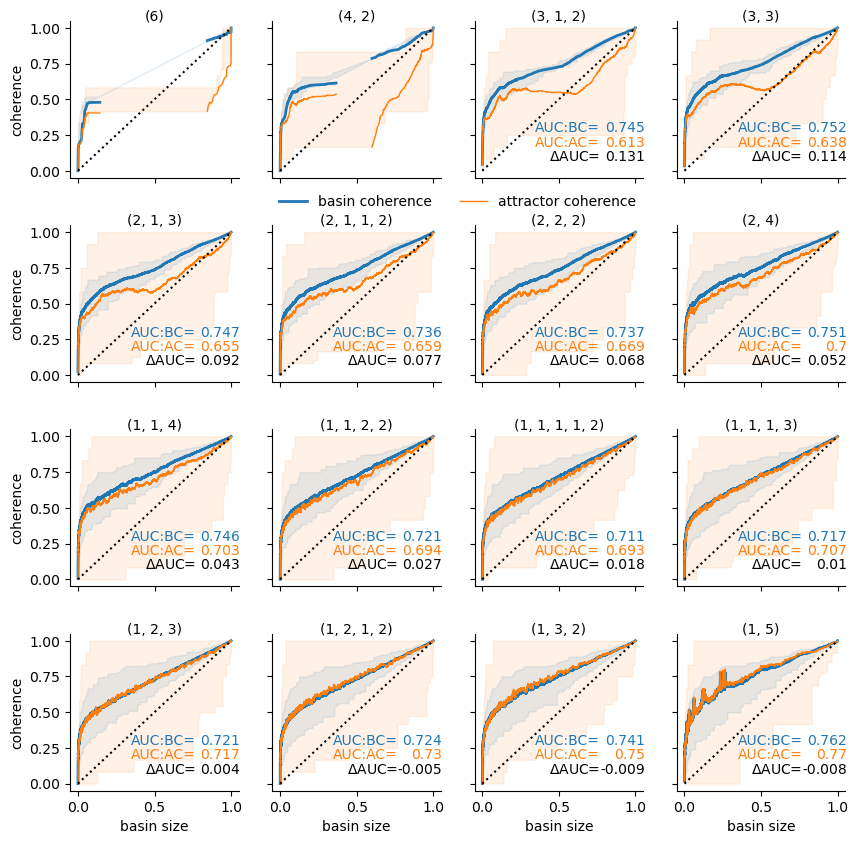

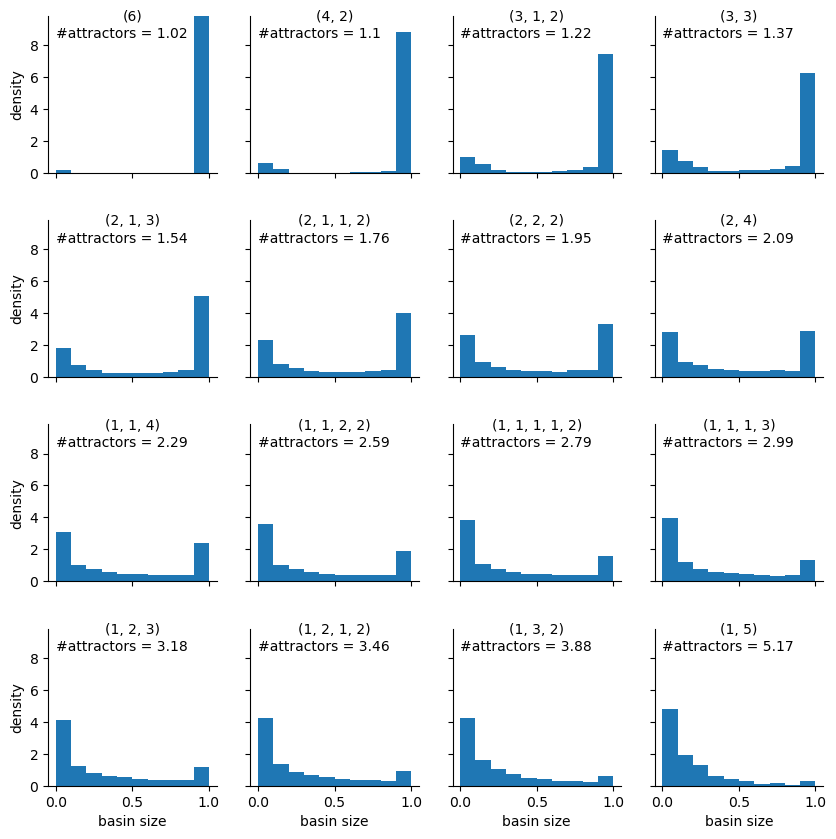

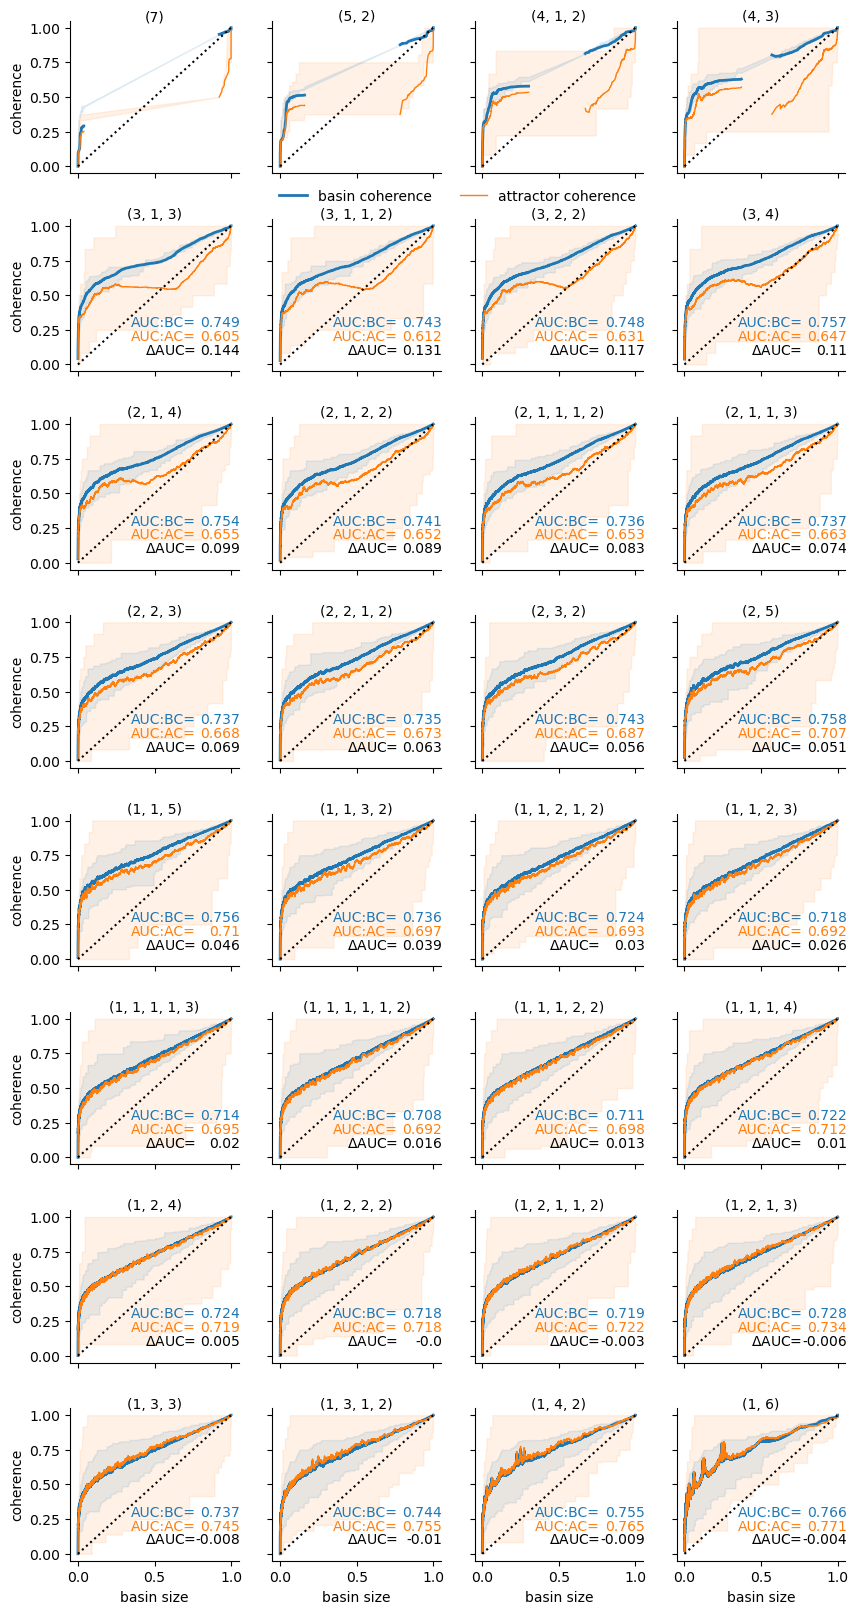

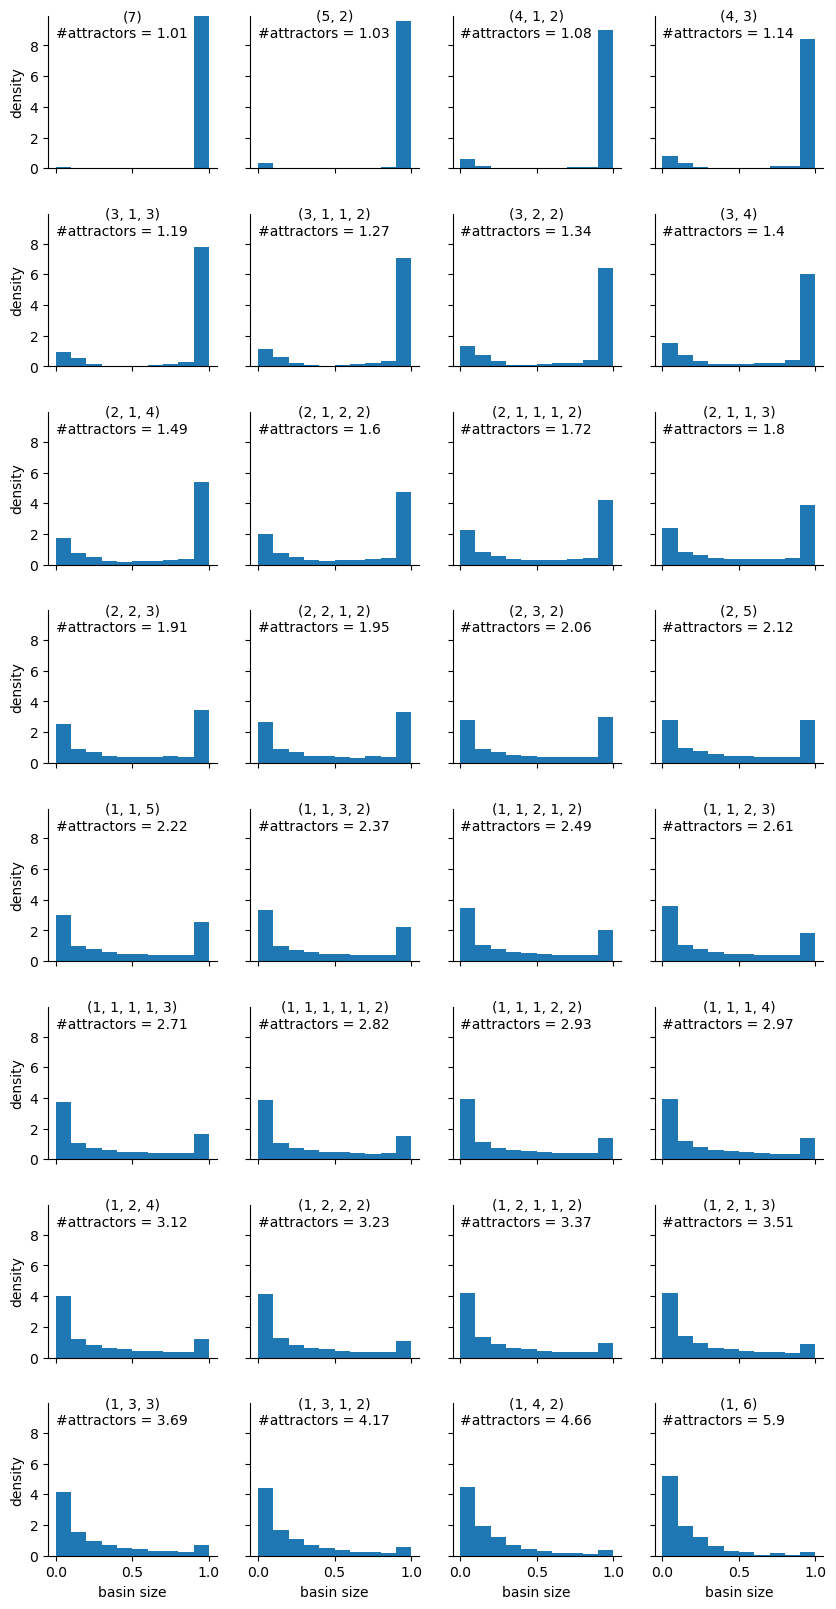

In [12]:
## Analyze data stratified by canalizing layer structure
# Load the pickle file
num_simulations = 10000
N = 12
ns = [3,4,5,6,7]

attractor_coherencess = []
attractor_lengthss = []
basin_coherencess = []
basin_sizess = []
frozen_core_coherencess = []
layer_structuress = []
for i,n in enumerate(ns):
    attractor_coherencess.append([])
    attractor_lengthss.append([])
    basin_coherencess.append([])
    basin_sizess.append([])
    frozen_core_coherencess.append([])
    layer_structuress.append([])
    for w in range(1,2**(n-1),2):
        layer_structure = boolforge.get_layer_structure_of_an_NCF_given_its_Hamming_weight(n,w)[-1]
        layer_structuress[-1].append(layer_structure)
        filename = f'data/layeredcanBN_{N}_{n}_{layer_structure}_{num_simulations}.pkl'
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            
        
            attractor_coherencess[-1].append( np.array([entry for sub_list in data['all_attractor_coherences'] for entry in sub_list]) )
            attractor_lengthss[-1].append( np.array([len(entry) for sub_list in data['all_attractors'] for entry in sub_list]) )
            basin_coherencess[-1].append( np.array([entry for sub_list in data['all_basin_coherences'] for entry in sub_list]) )
            basin_sizess[-1].append( np.array([entry for sub_list in data['all_basin_sizes'] for entry in sub_list]) )
            #frozen_core_coherencess[-1].append( np.array([entry[-1] for sub_list in data['all_frozen_core_coherence'] for entry in sub_list]) )


    
#generate mean values and AUC values
mean_attractor_coherencess = ([[np.mean(attractor_coherencess[i][j]) for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)])
mean_basin_coherencess = ([[np.mean(basin_coherencess[i][j]) for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)])

n_points = 100
auc_attractor_coherencess = ([[get_auc(basin_sizess[i][j],attractor_coherencess[i][j],n_points) for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)])
auc_basin_coherencess = ([[get_auc(basin_sizess[i][j],basin_coherencess[i][j],n_points) for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)])

max_gap_sizess = ([[max(np.sort(basin_sizess[i][j])[1:]-np.sort(basin_sizess[i][j])[:-1]) for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)])

max_length = 8
avg_n_attractors = ([[len(basin_sizess[i][j])/num_simulations for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)])
avg_n_m_cycles = ([[[sum(attractor_lengthss[i][j]==m)/num_simulations for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)] for m in range(1,max_length+1)])
avg_n_long_cycles = ([[sum(attractor_lengthss[i][j]>max_length)/num_simulations for j,layer_structure in enumerate(layer_structuress[i])] for i,n in enumerate(ns)])

#generate plot of attractor and basin coherencewith one panel per layer
cmap = matplotlib.cm.tab10
window_size = 100
for n in ns:
    index_n = ns.index(n)
    nrow = max(1,2**(n-4))
    ncol = min(4,2**(n-2))
    f,ax = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2.5*nrow),sharex='col',sharey='row')
    OPTION='area'
    SHOW_AUC_TEXT = True
    max_gap_size = 0.02
    for i in range(nrow):
        for j in range(ncol):
            idx = (i,j) if nrow>1 else j
            difference_basin_sizes =np.sort(basin_sizess[index_n][ncol*i+j])[1:]-np.sort(basin_sizess[index_n][ncol*i+j])[:-1]
            gap_size = max(difference_basin_sizes)
            ax[idx].spines[['right', 'top']].set_visible(False)
            indices = np.argsort(basin_sizess[index_n][ncol*i+j])
            if gap_size > max_gap_size:
                index_gap = np.argmax(difference_basin_sizes)+1
            if gap_size > max_gap_size:
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices[:index_gap]],rolling_mean(basin_coherencess[index_n][ncol*i+j][indices[:index_gap]],window_size),color=cmap(0),label='basin coherence',lw=2)
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices[:index_gap]],rolling_mean(attractor_coherencess[index_n][ncol*i+j][indices[:index_gap]],window_size),color=cmap(1),label='attractor coherence',lw=1)
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices[index_gap:]],rolling_mean(basin_coherencess[index_n][ncol*i+j][indices[index_gap:]],window_size),color=cmap(0),lw=2)
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices[index_gap:]],rolling_mean(attractor_coherencess[index_n][ncol*i+j][indices[index_gap:]],window_size),color=cmap(1),lw=1)
            else:
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices],0.5*np.array(rolling_mean(basin_coherencess[index_n][ncol*i+j][indices],window_size)) + 0.5*np.array(rolling_mean(basin_coherencess[index_n][ncol*i+j][indices][::-1],window_size)[::-1]),color=cmap(0),label='basin coherence',lw=2)
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices],0.5*np.array(rolling_mean(attractor_coherencess[index_n][ncol*i+j][indices],window_size)) + 0.5*np.array(rolling_mean(attractor_coherencess[index_n][ncol*i+j][indices][::-1],window_size)[::-1]),color=cmap(1),label='attractor coherence',lw=1)        
            if OPTION=='lines':
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices],running_max(basin_coherencess[index_n][ncol*i+j][indices]),color=cmap(0),ls=':',lw=1)
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices],running_min(basin_coherencess[index_n][ncol*i+j][indices]),color=cmap(0),ls=':',lw=1)
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices],running_max(attractor_coherencess[index_n][ncol*i+j][indices]),color=cmap(1),ls=':',lw=1)
                ax[idx].plot(basin_sizess[index_n][ncol*i+j][indices],running_min(attractor_coherencess[index_n][ncol*i+j][indices]),color=cmap(1),ls=':',lw=1)
            elif OPTION=='area':
                ax[idx].fill_between(basin_sizess[index_n][ncol*i+j][indices],running_min(attractor_coherencess[index_n][ncol*i+j][indices]),running_max(attractor_coherencess[index_n][ncol*i+j][indices]),color=cmap(1),alpha=0.1)
                ax[idx].fill_between(basin_sizess[index_n][ncol*i+j][indices],running_min(basin_coherencess[index_n][ncol*i+j][indices]),running_max(basin_coherencess[index_n][ncol*i+j][indices]),color=cmap(0),alpha=0.1)
                
            ax[idx].plot([0,1],[0,1],'k:')

           
            if i==nrow-1:
                ax[idx].set_xlabel('basin size')
            if j==0:
                ax[idx].set_ylabel('coherence')
            if i==0 and float(j)==ncol/2-1:
                print(n,i,j)
                ax[idx].legend(loc='center',ncol=2,frameon=False,bbox_to_anchor=[1.1,-0.3 if nrow==1 else -0.15])
            if SHOW_AUC_TEXT and gap_size < max_gap_size:
                ax[idx].text(0.77,0.3,'AUC:BC=',ha='right',va='center',color=cmap(0))
                ax[idx].text(0.77,0.2,'AUC:AC=',ha='right',va='center',color=cmap(1))
                ax[idx].text(0.77,0.1,r'$\Delta$'+'AUC=',ha='right',va='center',color='k')
                ax[idx].text(1.06,0.3,str(round(auc_basin_coherencess[index_n][ncol*i+j],3)),ha='right',va='center',color=cmap(0))
                ax[idx].text(1.06,0.2,str(round(auc_attractor_coherencess[index_n][ncol*i+j],3)),ha='right',va='center',color=cmap(1))
                ax[idx].text(1.06,0.1,str(round(auc_basin_coherencess[index_n][ncol*i+j]-auc_attractor_coherencess[index_n][ncol*i+j],3)),ha='right',va='center',color='k')
            ax[idx].text(0.5,1.03,str(layer_structuress[index_n][ncol*i+j]).replace('[','(').replace(']',')'),ha='center',va='bottom')
            #ax[idx].text(0.5,1.1,str(round(generate.random_nested_canalizing_function(n,layer_structuress[index_n][ncol*i+j]).get_average_sensitivity(EXACT=True,NORMALIZED=False),4)),ha='center',va='bottom')
    plt.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(img_dir, f'basin_vs_attractor_coherence_randomlayers_degree{n}_{N}_{num_simulations}_{window_size}_{OPTION}_{SHOW_AUC_TEXT}.pdf'),bbox_inches='tight')


    f,ax = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2.5*nrow),sharex='col',sharey='row')
    max_value=0
    for i in range(nrow):
        for j in range(ncol):
            idx = (i,j) if nrow>1 else j
            ax[idx].spines[['right', 'top']].set_visible(False)
            values = ax[idx].hist(basin_sizess[index_n][ncol*i+j],density=True,range=(0,1))[0]
            if max_value<max(values):
                max_value = max(values)
            if i==nrow-1:
                ax[idx].set_xlabel('basin size')
            if j==0:
                ax[idx].set_ylabel('density') 
        
    for i in range(nrow):
        for j in range(ncol):
            idx = (i,j) if nrow>1 else j            
            ax[idx].set_ylim([0,max_value])
            ax[idx].text(0.5,max_value*0.95,str(layer_structuress[index_n][ncol*i+j]).replace('[','(').replace(']',')'),ha='center',va='bottom')
            ax[idx].text(0,max_value*0.84,'#attractors = '+str(round(avg_n_attractors[index_n][ncol*i+j],2)),ha='left',va='bottom')
            
    plt.subplots_adjust(hspace=0.3)
    # plt.savefig(os.path.join(img_dir, f'basinsize_distribution_randomlayers_degree{n}_{N}_{num_simulations}.pdf'),bbox_inches='tight')

In [13]:
input_redundancies = []
strengths = []
biases = []
all_layer_structures = []
aucs_basin = []
aucs_attractor = []
difference_aucs = []
avg_sens = []
avg_n_attr = []
avg_m_cycles = []
avg_long_cycles = []
for ii,n in enumerate(ns):
    for layer_structure,auc_b,auc_a in zip(layer_structuress[ii],auc_basin_coherencess[ii],auc_attractor_coherencess[ii]):
        f = boolforge.random_function(n,layer_structure=layer_structure)
        input_redundancies.append(f.get_input_redundancy())
        strengths.append(f.get_canalizing_strength()[0])
        biases.append(f.get_absolute_bias())
        avg_sens.append(f.get_average_sensitivity(NORMALIZED=False,EXACT=True))
        all_layer_structures.append(layer_structure)
        aucs_basin.append(auc_b)
        aucs_attractor.append(auc_a)
        difference_aucs.append(auc_b - auc_a)
        

df = pd.DataFrame(np.c_[list(map(str,all_layer_structures)),aucs_basin,aucs_attractor,difference_aucs,
                   biases,avg_sens,
                   input_redundancies,strengths,
                   boolforge.flatten(avg_n_attractors),
                   np.array([boolforge.flatten(avg_n_m_cycles[m]) for m in range(max_length)]).T,
                   boolforge.flatten(avg_n_long_cycles)],
             columns = ['layer strcucture','AUC basin coherence','AUC attractor coherence','Delta AUC',
                        'Absolute bias','Average sensitivity','Input redundancy','Canalizing strength',
                        'Number attractors']+[f'Number {m}-cycles' for m in range(1,max_length+1)] + [f'Number of cycles of length > {max_length}'])
pd.ExcelWriter(f'basin_vs_attractor_coherence_layers_ns{ns}.xlsx', engine='xlsxwriter')

writer = pd.ExcelWriter(f'basin_vs_attractor_coherence_layers_ns{ns}.xlsx',
                        engine='xlsxwriter',
                        engine_kwargs={'options': {'strings_to_numbers': True}})
df.to_excel(writer)
writer.close()

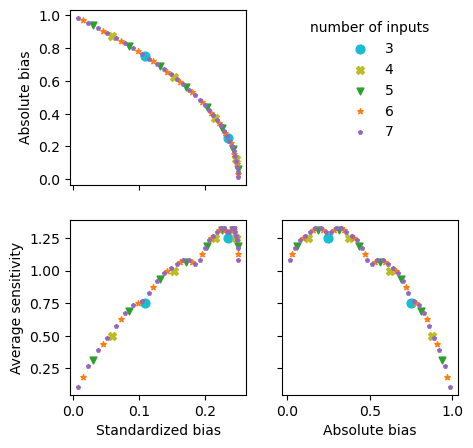

In [14]:
ns_to_plot = ns
ncol = 2
nrow = 2
fig,ax = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2.5*nrow),sharex='col',sharey='row')
markers = ['o','X','v','*','p']
colors = [cmap(1.),cmap(0.88),cmap(0.2),cmap(0.1),cmap(0.4)]
max_gap_size=0.02
for n in ns_to_plot:
    ii = ns.index(n)
    biases = []
    standardized_biases = []
    avg_sens = []
    for layer_structure,auc_b,auc_a,gap_size in zip(layer_structuress[ii],auc_basin_coherencess[ii],auc_attractor_coherencess[ii],max_gap_sizess[ii]):
        f = boolforge.random_nested_canalizing_function(n,layer_structure=layer_structure)
        biases.append(f.get_absolute_bias())
        standardized_biases.append(sum(f.f)*(len(f)-sum(f.f))/len(f)**2)
        avg_sens.append(f.get_average_sensitivity(NORMALIZED=False,EXACT=True))
    for iii,(values_y,name_y) in enumerate(zip([biases,avg_sens],['Absolute bias','Average sensitivity'])):
        for jjj,(values_x,name_x) in enumerate(zip([standardized_biases,biases],['Standardized bias','Absolute bias'])):
            if iii == 0 and jjj==1:
                ax[iii,jjj].axis('off')
                continue
            ax[iii,jjj].scatter(np.array(values_x),np.array(values_y),label=str(n),marker=markers[ii],color=colors[ii],s=8*(8-n))

            if iii == 1:
                ax[iii,jjj].set_xlabel(name_x)
            if jjj == 0:
                ax[iii,jjj].set_ylabel(name_y)
            if iii == 1 and jjj == 1:
                ax[iii,jjj].legend(loc='center',ncol=1,frameon=False,bbox_to_anchor=[0.5,1.8],title='number of inputs')
plt.savefig(os.path.join(img_dir,'basin_vs_attractor_coherence_layers_bias_avgsens.pdf'),bbox_inches='tight')

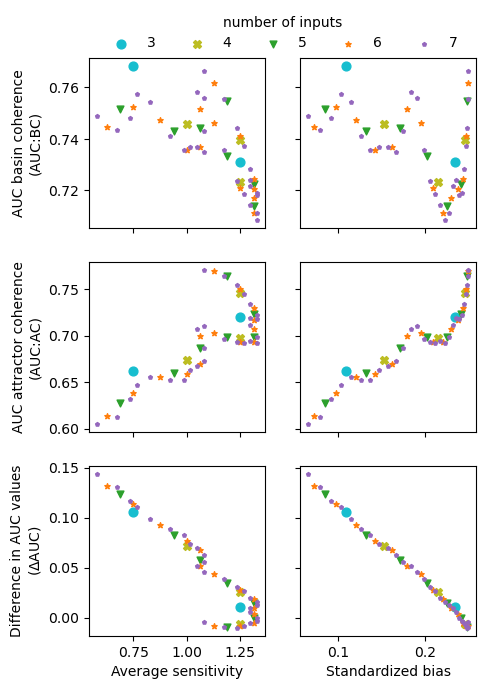

In [15]:
#Figure 9
cmap = matplotlib.cm.tab10

ns_to_plot = ns
ncol = 2
nrow = 3
fig,ax = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2.5*nrow),sharex='col',sharey='row')
markers = ['o','X','v','*','p']
colors = [cmap(1.),cmap(0.88),cmap(0.2),cmap(0.1),cmap(0.4)]
max_gap_size=0.02
for n in ns_to_plot:
    ii = ns.index(n)
    input_redundancies = []
    average_degrees = []
    strengths = []
    biases = []
    standardized_biases = []
    all_layer_structures = []
    aucs_basin = []
    aucs_attractor = []
    difference_aucs = []
    avg_sens = []
    bias_prod_times_eff_degrees = []
    gap_sizes = []
    for layer_structure,auc_b,auc_a,gap_size in zip(layer_structuress[ii],auc_basin_coherencess[ii],auc_attractor_coherencess[ii],max_gap_sizess[ii]):
        f = boolforge.random_nested_canalizing_function(n,layer_structure=layer_structure)
        input_redundancies.append(f.get_input_redundancy())
        average_degrees.append(n*(1-input_redundancies[-1]))
        strengths.append(f.get_canalizing_strength()[0])
        biases.append(f.get_absolute_bias())
        standardized_biases.append(sum(f.f)*(len(f)-sum(f.f))/len(f)**2)
        avg_sens.append(f.get_average_sensitivity(NORMALIZED=False,EXACT=True))
        all_layer_structures.append(layer_structure)
        aucs_basin.append(auc_b)
        aucs_attractor.append(auc_a)
        difference_aucs.append(auc_b - auc_a)
        bias_prod_times_eff_degrees.append(0.25*(1-biases[-1]**2) * n * (1-input_redundancies[-1]))
        gap_sizes.append(gap_size)
    for iii,(values_y,name_y) in enumerate(zip([aucs_basin,aucs_attractor,difference_aucs],['AUC basin coherence\n(AUC:BC)','AUC attractor coherence\n(AUC:AC)','Difference in AUC values\n('+r'$\Delta$AUC)'])):
        for jjj,(values_x,name_x) in enumerate(zip([avg_sens,standardized_biases],['Average sensitivity','Standardized bias'])):
            indices = np.array(gap_sizes)<max_gap_size
            ax[iii,jjj].scatter(np.array(values_x)[indices],np.array(values_y)[indices],label=str(n),marker=markers[ii],color=colors[ii],s=8*(8-n))
            if iii == 2:
                ax[iii,jjj].set_xlabel(name_x)
            if jjj == 0:
                ax[iii,jjj].set_ylabel(name_y)
            if iii == 0 and jjj == 1:
                ax[iii,jjj].legend(loc='center',ncol=5,frameon=False,bbox_to_anchor=[-0.1,1.15],title='number of inputs')
plt.savefig(os.path.join(img_dir,f'basin_vs_attractor_coherence_layers_3_by_{ncol}_ns{ns}.pdf'),bbox_inches='tight')

3 0 1
4 0 1
5 0 1


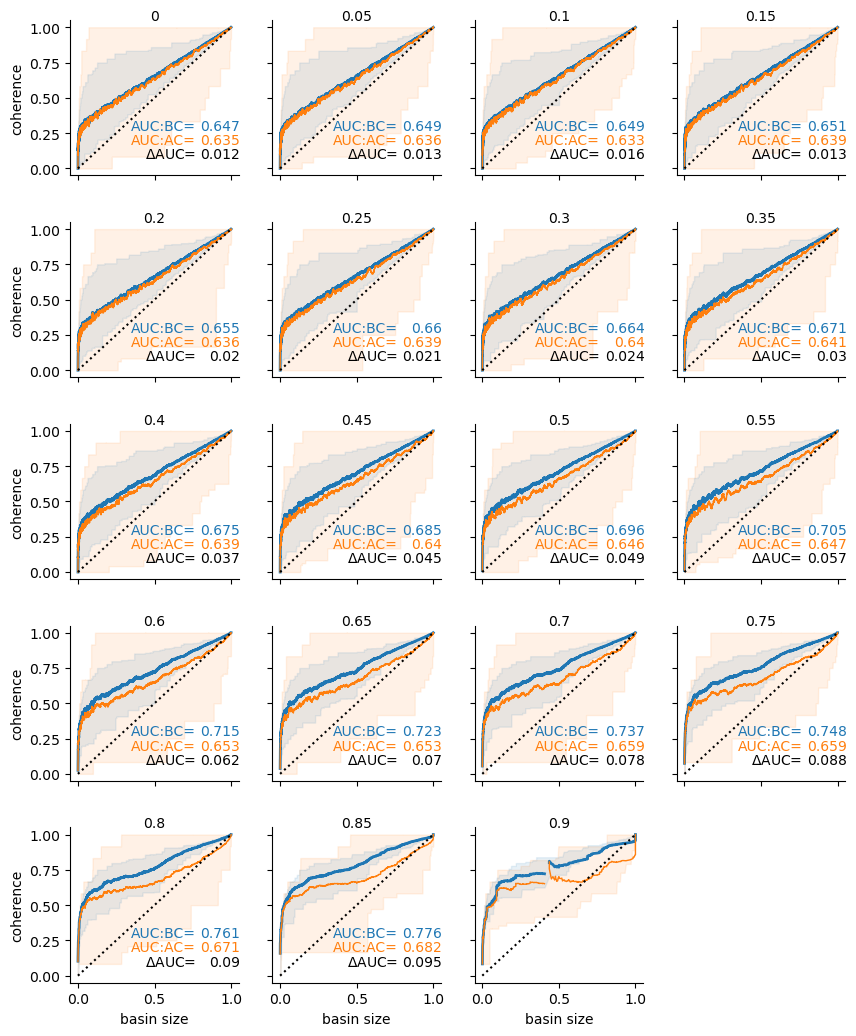

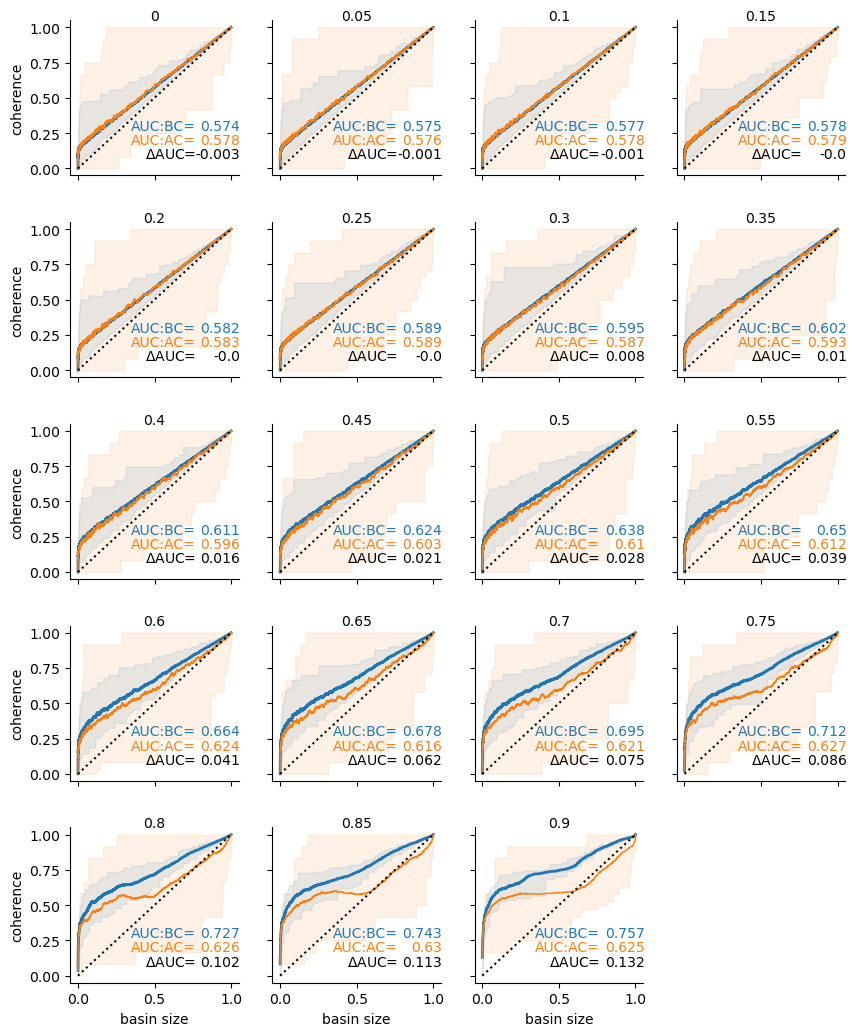

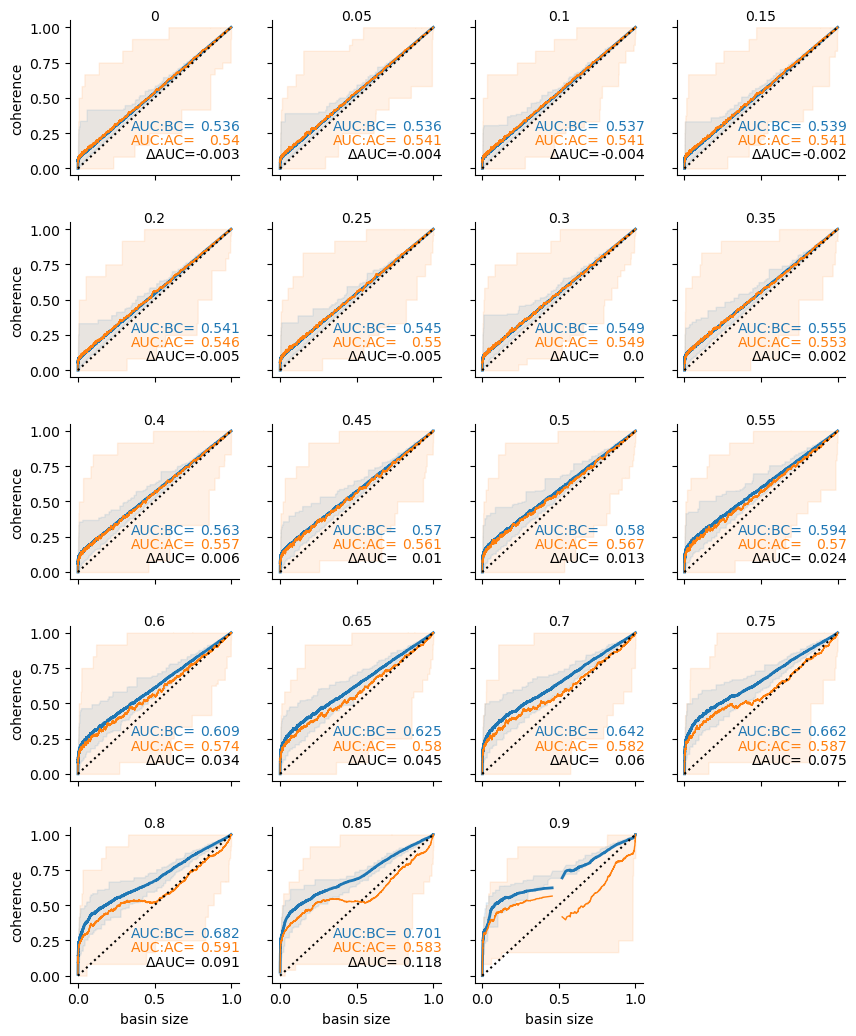

In [12]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Define your variables
num_simulations = 10000
N = 12
ns = [3, 4, 5]
attractor_coherencess = []
attractor_lengthss = []
basin_coherencess = []
basin_sizess = []
frozen_core_coherencess = []
biases = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

# Load data
for i, n in enumerate(ns):
    attractor_coherencess.append([])
    attractor_lengthss.append([])
    basin_coherencess.append([])
    basin_sizess.append([])
    frozen_core_coherencess.append([])

    for bias in biases:
        filename = f'data/absolutebias_{N}_{n}_{bias}_{num_simulations}.pkl'
        filename = os.path.join(notebook_dir, filename)
        with open(filename, 'rb') as f:
            data = pickle.load(f)

            attractor_coherencess[-1].append(np.array([entry for matrix in data['all_attractor_markov_matrix'] for entry in (matrix.diagonal() if len(matrix) > 1 else matrix)]))
            attractor_lengthss[-1].append(np.array([len(entry) for sub_list in data['all_attractors'] for entry in sub_list]))
            basin_coherencess[-1].append(np.array([entry for sub_list in data['all_basin_coherence'] for entry in sub_list]))
            basin_sizess[-1].append(np.array([entry for sub_list in data['all_basin_sizes'] for entry in sub_list]))

# Calculate means and AUCs
mean_attractor_coherencess = ([[np.mean(attractor_coherencess[i][j]) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])
mean_basin_coherencess = ([[np.mean(basin_coherencess[i][j]) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])

n_points = 1000
auc_attractor_coherencess = ([[get_auc(basin_sizess[i][j], attractor_coherencess[i][j], n_points) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])
auc_basin_coherencess = ([[get_auc(basin_sizess[i][j], basin_coherencess[i][j], n_points) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])

max_gap_sizess = ([[max(np.sort(basin_sizess[i][j] / 2**N)[1:] - np.sort(basin_sizess[i][j] / 2**N)[:-1]) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])

max_length = 8
avg_n_attractors = ([[len(basin_sizess[i][j]) / num_simulations for j, bias in enumerate(biases)] for i, n in enumerate(ns)])
avg_n_m_cycles = ([[[sum(attractor_lengthss[i][j] == m) / num_simulations for j, bias in enumerate(biases)] for i, n in enumerate(ns)] for m in range(1, max_length + 1)])
avg_n_long_cycles = ([[sum(attractor_lengthss[i][j] > max_length) / num_simulations for j, bias in enumerate(biases)] for i, n in enumerate(ns)])

# Generate plots
cmap = matplotlib.cm.tab10
window_size = 100
for n in ns:
    index_n = ns.index(n)
    nrow = 5
    ncol = 4
    f, ax = plt.subplots(nrow, ncol, figsize=(2.5 * ncol, 2.5 * nrow), sharex='col', sharey='row')
    OPTION = 'area'
    SHOW_AUC_TEXT = True
    max_gap_size = 0.02
    for i in range(nrow):
        for j in range(ncol):
            idx = (i, j) if nrow > 1 else j
            plot_index = ncol * i + j
            if plot_index >= len(biases):
                f.delaxes(ax[idx])
                continue
            difference_basin_sizes = np.sort(basin_sizess[index_n][plot_index] / 2**N)[1:] - np.sort(basin_sizess[index_n][plot_index] / 2**N)[:-1]
            gap_size = max(difference_basin_sizes)
            ax[idx].spines[['right', 'top']].set_visible(False)
            indices = np.argsort(basin_sizess[index_n][plot_index])
            if gap_size > max_gap_size:
                index_gap = np.argmax(difference_basin_sizes) + 1
                ax[idx].plot(basin_sizess[index_n][plot_index][indices[:index_gap]] / 2**N, rolling_mean(basin_coherencess[index_n][plot_index][indices[:index_gap]], window_size), color=cmap(0), label='basin coherence', lw=2)
                ax[idx].plot(basin_sizess[index_n][plot_index][indices[:index_gap]] / 2**N, rolling_mean(attractor_coherencess[index_n][plot_index][indices[:index_gap]], window_size), color=cmap(1), label='attractor coherence', lw=1)
                ax[idx].plot(basin_sizess[index_n][plot_index][indices[index_gap:]] / 2**N, rolling_mean(basin_coherencess[index_n][plot_index][indices[index_gap:]], window_size), color=cmap(0), lw=2)
                ax[idx].plot(basin_sizess[index_n][plot_index][indices[index_gap:]] / 2**N, rolling_mean(attractor_coherencess[index_n][plot_index][indices[index_gap:]], window_size), color=cmap(1), lw=1)
            else:
                ax[idx].plot(basin_sizess[index_n][plot_index][indices] / 2**N, 0.5 * np.array(rolling_mean(basin_coherencess[index_n][plot_index][indices], window_size)) + 0.5 * np.array(rolling_mean(basin_coherencess[index_n][plot_index][indices][::-1], window_size)[::-1]), color=cmap(0), label='basin coherence', lw=2)
                ax[idx].plot(basin_sizess[index_n][plot_index][indices] / 2**N, 0.5 * np.array(rolling_mean(attractor_coherencess[index_n][plot_index][indices], window_size)) + 0.5 * np.array(rolling_mean(attractor_coherencess[index_n][plot_index][indices][::-1], window_size)[::-1]), color=cmap(1), label='attractor coherence', lw=1)
            if OPTION == 'lines':
                ax[idx].plot(basin_sizess[index_n][plot_index][indices] / 2**N, running_max(basin_coherencess[index_n][plot_index][indices]), color=cmap(0), ls=':', lw=1)
                ax[idx].plot(basin_sizess[index_n][plot_index][indices] / 2**N, running_min(basin_coherencess[index_n][plot_index][indices]), color=cmap(0), ls=':', lw=1)
                ax[idx].plot(basin_sizess[index_n][plot_index][indices] / 2**N, running_max(attractor_coherencess[index_n][plot_index][indices]), color=cmap(1), ls=':', lw=1)
                ax[idx].plot(basin_sizess[index_n][plot_index][indices] / 2**N, running_min(attractor_coherencess[index_n][plot_index][indices]), color=cmap(1), ls=':', lw=1)
            elif OPTION == 'area':
                ax[idx].fill_between(basin_sizess[index_n][plot_index][indices] / 2**N, running_min(attractor_coherencess[index_n][plot_index][indices]), running_max(attractor_coherencess[index_n][plot_index][indices]), color=cmap(1), alpha=0.1)
                ax[idx].fill_between(basin_sizess[index_n][plot_index][indices] / 2**N, running_min(basin_coherencess[index_n][plot_index][indices]), running_max(basin_coherencess[index_n][plot_index][indices]), color=cmap(0), alpha=0.1)

            ax[idx].plot([0, 1], [0, 1], 'k:')
            if i == nrow - 1:
                ax[idx].set_xlabel('basin size')
            if j == 0:
                ax[idx].set_ylabel('coherence')
            if i == 0 and float(j) == ncol / 2 - 1:
                print(n, i, j)

            if SHOW_AUC_TEXT and gap_size < max_gap_size:
                ax[idx].text(0.77, 0.3, 'AUC:BC=', ha='right', va='center', color=cmap(0))
                ax[idx].text(0.77, 0.2, 'AUC:AC=', ha='right', va='center', color=cmap(1))
                ax[idx].text(0.77, 0.1, r'$\Delta$' + 'AUC=', ha='right', va='center', color='k')
                ax[idx].text(1.06, 0.3, str(round(auc_basin_coherencess[index_n][plot_index], 3)), ha='right', va='center', color=cmap(0))
                ax[idx].text(1.06, 0.2, str(round(auc_attractor_coherencess[index_n][plot_index], 3)), ha='right', va='center', color=cmap(1))
                ax[idx].text(1.06, 0.1, str(round(auc_basin_coherencess[index_n][plot_index] - auc_attractor_coherencess[index_n][plot_index], 3)), ha='right', va='center', color='k')
            ax[idx].text(0.5, 1.03, str(biases[plot_index]).replace('[', '(').replace(']', ')'), ha='center', va='bottom')
            # ax[idx].text(0.5, 1.1, str(round(generate.random_nested_canalizing_function(n, layer_structuress[index_n][plot_index]).get_average_sensitivity(EXACT=True, NORMALIZED=False), 4)), ha='center', va='bottom')
    plt.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(img_dir, f'basin_vs_attractor_coherence_absolutebias_degree{n}_{N}_{num_simulations}_{window_size}_{OPTION}_{SHOW_AUC_TEXT}.pdf'), bbox_inches='tight')


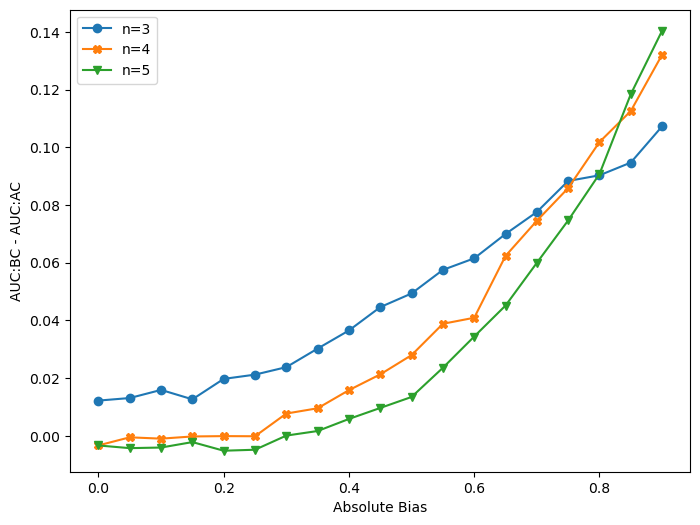

In [ ]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Define your variables
num_simulations = 10000
N = 12
ns = [3, 4, 5]
attractor_coherencess = []
attractor_lengthss = []
basin_coherencess = []
basin_sizess = []
frozen_core_coherencess = []
biases = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

# Load data
for i, n in enumerate(ns):
    attractor_coherencess.append([])
    attractor_lengthss.append([])
    basin_coherencess.append([])
    basin_sizess.append([])
    frozen_core_coherencess.append([])

    for bias in biases:
        filename = f'data/absolutebias_{N}_{n}_{bias}_{num_simulations}.pkl'
        filename = os.path.join(notebook_dir, filename)
        with open(filename, 'rb') as f:
            data = pickle.load(f)

            attractor_coherencess[-1].append(np.array([entry for matrix in data['all_attractor_markov_matrix'] for entry in (matrix.diagonal() if len(matrix) > 1 else matrix)]))
            attractor_lengthss[-1].append(np.array([len(entry) for sub_list in data['all_attractors'] for entry in sub_list]))
            basin_coherencess[-1].append(np.array([entry for sub_list in data['all_basin_coherence'] for entry in sub_list]))
            basin_sizess[-1].append(np.array([entry for sub_list in data['all_basin_sizes'] for entry in sub_list]))

# Calculate means and AUCs
mean_attractor_coherencess = ([[np.mean(attractor_coherencess[i][j]) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])
mean_basin_coherencess = ([[np.mean(basin_coherencess[i][j]) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])

n_points = 1000
auc_attractor_coherencess = ([[get_auc(basin_sizess[i][j], attractor_coherencess[i][j], n_points) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])
auc_basin_coherencess = ([[get_auc(basin_sizess[i][j], basin_coherencess[i][j], n_points) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])

max_gap_sizess = ([[max(np.sort(basin_sizess[i][j] / 2**N)[1:] - np.sort(basin_sizess[i][j] / 2**N)[:-1]) for j, bias in enumerate(biases)] for i, n in enumerate(ns)])

max_length = 8
avg_n_attractors = ([[len(basin_sizess[i][j]) / num_simulations for j, bias in enumerate(biases)] for i, n in enumerate(ns)])
avg_n_m_cycles = ([[[sum(attractor_lengthss[i][j] == m) / num_simulations for j, bias in enumerate(biases)] for i, n in enumerate(ns)] for m in range(1, max_length + 1)])
avg_n_long_cycles = ([[sum(attractor_lengthss[i][j] > max_length) / num_simulations for j, bias in enumerate(biases)] for i, n in enumerate(ns)])


cmap = matplotlib.cm.tab10
markers = ['o','X','v','*','p']

# Plot the bias vs auc_attractor_coherencess - auc_basin_coherencess
fig = plt.figure(figsize=(8, 6))
for i, n in enumerate(ns):
    plt.plot(biases, np.array(auc_basin_coherencess[i]) - np.array(auc_attractor_coherencess[i]), label=f'n={n}', marker=markers[i])
plt.xlabel('Absolute Bias')
plt.ylabel('AUC:BC - AUC:AC')
plt.legend()
plt.show()





# ns_to_plot = ns
# ncol = 2
# nrow = 3
# fig,ax = plt.subplots(nrow,ncol,figsize=(2.5*ncol,2.5*nrow),sharex='col',sharey='row')
# markers = ['o','X','v','*','p']
# colors = [cmap(1.),cmap(0.88),cmap(0.2),cmap(0.1),cmap(0.4)]
# max_gap_size=0.02
# for n in ns_to_plot:
#     ii = ns.index(n)
#     input_redundancies = []
#     average_degrees = []
#     strengths = []
#     biases = []
#     standardized_biases = []
#     all_layer_structures = []
#     aucs_basin = []
#     aucs_attractor = []
#     difference_aucs = []
#     avg_sens = []
#     bias_prod_times_eff_degrees = []
#     gap_sizes = []
#     for layer_structure,auc_b,auc_a,gap_size in zip(layer_structuress[ii],auc_basin_coherencess[ii],auc_attractor_coherencess[ii],max_gap_sizess[ii]):
#         f = boolforge.random_nested_canalizing_function(n,layer_structure=layer_structure)
#         input_redundancies.append(f.get_input_redundancy())
#         average_degrees.append(n*(1-input_redundancies[-1]))
#         strengths.append(f.get_canalizing_strength()[0])
#         biases.append(f.get_absolute_bias())
#         standardized_biases.append(sum(f.f)*(len(f)-sum(f.f))/len(f)**2)
#         avg_sens.append(f.get_average_sensitivity(NORMALIZED=False,EXACT=True))
#         all_layer_structures.append(layer_structure)
#         aucs_basin.append(auc_b)
#         aucs_attractor.append(auc_a)
#         difference_aucs.append(auc_b - auc_a)
#         bias_prod_times_eff_degrees.append(0.25*(1-biases[-1]**2) * n * (1-input_redundancies[-1]))
#         gap_sizes.append(gap_size)
#     for iii,(values_y,name_y) in enumerate(zip([aucs_basin,aucs_attractor,difference_aucs],['AUC basin coherence\n(AUC:BC)','AUC attractor coherence\n(AUC:AC)','Difference in AUC values\n('+r'$\Delta$AUC)'])):
#         for jjj,(values_x,name_x) in enumerate(zip([avg_sens,standardized_biases],['Average sensitivity','Standardized bias'])):
#             indices = np.array(gap_sizes)<max_gap_size
#             ax[iii,jjj].scatter(np.array(values_x)[indices],np.array(values_y)[indices],label=str(n),marker=markers[ii],color=colors[ii],s=8*(8-n))
#             if iii == 2:
#                 ax[iii,jjj].set_xlabel(name_x)
#             if jjj == 0:
#                 ax[iii,jjj].set_ylabel(name_y)
#             if iii == 0 and jjj == 1:
#                 ax[iii,jjj].legend(loc='center',ncol=5,frameon=False,bbox_to_anchor=[-0.1,1.15],title='number of inputs')
# plt.savefig(os.path.join(img_dir,f'basin_vs_attractor_coherence_layers_3_by_{ncol}_ns{ns}.pdf'),bbox_inches='tight')


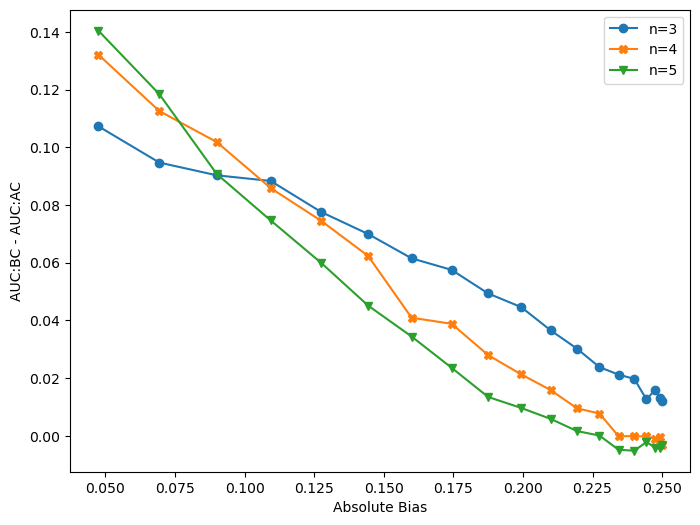

In [16]:
fig = plt.figure(figsize=(8, 6))
for i, n in enumerate(ns):
    plt.plot([(1-b**2)/4 for b in biases], np.array(auc_basin_coherencess[i]) - np.array(auc_attractor_coherencess[i]), label=f'n={n}', marker=markers[i])
plt.xlabel('Absolute Bias')
plt.ylabel('AUC:BC - AUC:AC')
plt.legend()
plt.show()

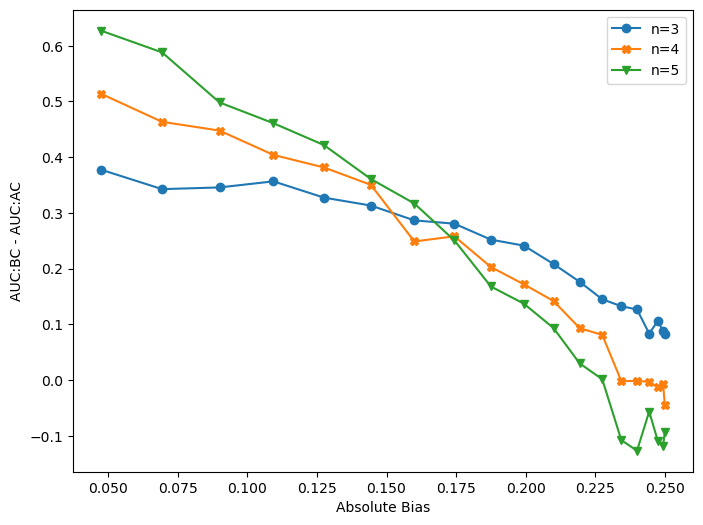

In [17]:
fig = plt.figure(figsize=(8, 6))
for i, n in enumerate(ns):
    plt.plot([(1-b**2)/4 for b in biases], (np.array(auc_basin_coherencess[i]) - np.array(auc_attractor_coherencess[i]))/(np.array(auc_basin_coherencess[i])  -0.5), label=f'n={n}', marker=markers[i])
plt.xlabel('Absolute Bias')
plt.ylabel('AUC:BC - AUC:AC')
plt.legend()
plt.show()